# Benchmarking Annotation Storage

First we define a function to generate some test data. here we create some simple artificial cell boundaries by creating a circle of points, adding some noise, scale to introduce eccentricity, and then rotating. We use 20 points per cell, which is a reasonably high value for cell annotation. However, this can be adjusted.

In [182]:
import sys

sys.path.append("..")  # If running locally without pypi installed tiatoolbox

from typing import Tuple, Generator
from numbers import Number

import numpy as np

from tiatoolbox.annotation.storage import Polygon


def cell_polygon(
    xy: Tuple[Number, Number],
    n_points: int = 20,
    radius: Number = 10,
    noise: Number = 1,
    eccentricity: Tuple[Number, Number] = (1, 3),
    repeat_first: bool = True,
    direction: str = "CCW",
    seed: int = None,
) -> Polygon:
    """Generate an aritifical cell boundary polygon.

    This is modified from the tiatoolbox unit tests.

    Cell boundaries are generated an ellipsoids with randomised eccentricity,
    added noise, and a random rotation.

    Args:
        xy (tuple(int)): The x,y centre point to generate the cell boundary around.
        n_points (int): Number of points in the boundary. Defaults to 20.
        radius (float): Radius of the points from the centre. Defaults to 10.
        noise (float): Noise to add to the point locations. Defaults to 1.
        eccentricity (tuple(float)): Range of values (low, high) to use for
            randomised eccentricity. Defaults to (1, 3).
        repeat_first (bool): Enforce that the last point is equal to the first.
        direction (str): Ordering of the points. Defaults to "CCW". Valid options
            are: counter-clockwise "CCW", and clockwise "CW".

    """
    from shapely import affinity

    if seed is not None:
        random_state = np.random.get_state()
        np.random.seed(seed)

    if repeat_first:
        n_points -= 1

    # Generate points about an ellipse with random eccentricity
    x, y = xy
    alpha = np.linspace(0, 2 * np.pi - (2 * np.pi / n_points), n_points)
    rx = radius * (np.random.rand() + 0.5)
    ry = np.random.uniform(*eccentricity) * radius - rx
    x = rx * np.cos(alpha) + x + (np.random.rand(n_points) - 0.5) * noise
    y = ry * np.sin(alpha) + y + (np.random.rand(n_points) - 0.5) * noise
    boundary_coords = np.stack([x, y], axis=1).astype(int).tolist()

    # Copy first coordinate to the end if required
    if repeat_first:
        boundary_coords = boundary_coords + [boundary_coords[0]]

    # Swap direction
    if direction.strip().lower() == "cw":
        boundary_coords = boundary_coords[::-1]

    polygon = Polygon(boundary_coords)

    # Add random rotation
    angle = np.random.rand() * 360

    if seed is not None:
        np.random.set_state(random_state)

    return affinity.rotate(polygon, angle, origin="centroid").buffer(1)


## Display Some Examples Cell Boundaries

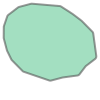

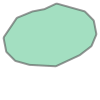

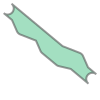

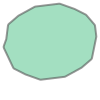

In [211]:
from IPython.display import display


for n in range(4):
    display(cell_polygon(xy=(0, 0), n_points=20, repeat_first=False, seed=n))

## Create a Dataset of Cell Boundaries

Here we create a function to generate grid of cells for testing. It uses a fixed seed for reproducibility.

In [185]:
def cell_grid(
    size: Tuple[int, int] = (10, 10), spacing: Number = 25
) -> Generator[Polygon, None, None]:
    return (
        cell_polygon(xy=np.multiply(ij, spacing), repeat_first=False, seed=n)
        for n, ij in enumerate(np.ndindex(size))
    )

## Display a Sample 5×5 Grid

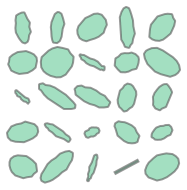

In [186]:
from shapely.geometry import MultiPolygon

MultiPolygon(polygons=list(cell_grid(size=(5, 5), spacing=35)))

## Time Creating Different Kinds of Annotation Store Objects

Here we test:

1. A python dictionary based store (DictionaryStore)
2. An SQLite database based store (SQLiteStore)

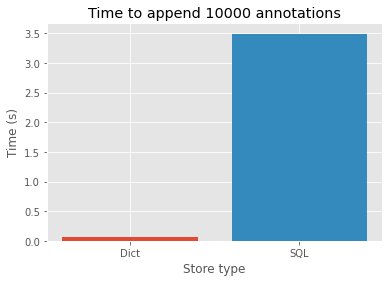

In [204]:
from time import perf_counter

from matplotlib import pyplot as plt

plt.style.use("ggplot")

from tiatoolbox.annotation.storage import Annotation, DictionaryStore, SQLiteStore

# Convert to annotations (a dataclass paring a geometry and (optional)
# key-value properties)
annotations = [Annotation(polygon) for polygon in cell_grid(size=(100, 100), spacing=35)]
dict_store = DictionaryStore()
sql_store = SQLiteStore()

# Time dictionary store
t0 = perf_counter()
dict_store.append_many(annotations)
dict_dt = perf_counter() - t0

# Time SQLite store
t0 = perf_counter()
sql_store.append_many(annotations)
sql_dt = perf_counter() - t0

# Plot the results
plt.bar(x=range(2), height=[dict_dt, sql_dt], color=["C0", "C1"], tick_label=["Dict", "SQL"])
plt.title(f"Time to append {100 * 100} annotations")
plt.xlabel("Store type")
plt.ylabel("Time (s)")
plt.show()

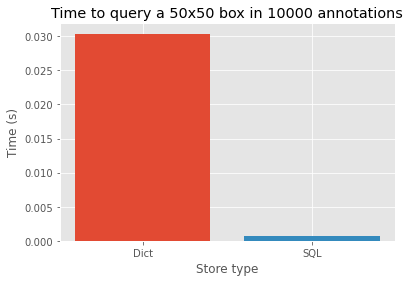

In [207]:
# Time a simple box query
box = Polygon.from_bounds(50, 50, 100, 100)

# Time dictionary store
t0 = perf_counter()
dict_store.query(box)
dict_dt = perf_counter() - t0

# Time SQLite store
t0 = perf_counter()
sql_store.query(box)
sql_dt = perf_counter() - t0

# Plot the results
plt.bar(x=range(2), height=[dict_dt, sql_dt], color=["C0", "C1"], tick_label=["Dict", "SQL"])
plt.title(f"Time to query a 50x50 box in {100 * 100} annotations")
plt.xlabel("Store type")
plt.ylabel("Time (s)")
plt.show()

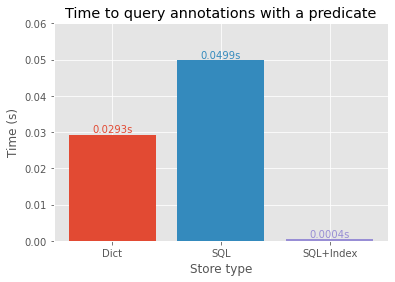

In [248]:
# Time a predicate query
import copy

labelled_annotations = copy.deepcopy(annotations)
for n, annotation in enumerate(labelled_annotations):
    annotation.properties["class"] = n

box = Polygon.from_bounds(0, 0, 1000, 1000)
predicate = "props['class'] == 0"

dict_store = DictionaryStore()
sql_store = SQLiteStore()

dict_store.append_many(labelled_annotations)
sql_store.append_many(labelled_annotations)

# Time dictionary store
t0 = perf_counter()
dict_result = dict_store.query(box, where=predicate)
dict_dt = perf_counter() - t0

# Time SQLite store
t0 = perf_counter()
sql_result = sql_store.query(box, where=predicate)
sql_dt = perf_counter() - t0

# Add an index
sql_store.create_index("class_lookup", "props['class']")

# Time SQLite store again
t0 = perf_counter()
sql_index_result = sql_store.query(box, where=predicate)
sql_index_dt = perf_counter() - t0

# Validate the results against each other
for a, b, c in zip(dict_result, sql_result, sql_index_result):
    assert a.geometry == b.geometry == c.geometry

# Plot the results
plt.bar(x=range(3), height=[dict_dt, sql_dt, sql_index_dt], color=["C0", "C1", "C2"], tick_label=["Dict", "SQL", "SQL+Index"])
plt.title(f"Time to query annotations with a predicate")
plt.text(x=0, y=dict_dt, s=f"{dict_dt:.4f}s", color="C0", ha="center", va="bottom")
plt.text(x=1, y=sql_dt, s=f"{sql_dt:.4f}s", color="C1", ha="center", va="bottom")
plt.text(x=2, y=sql_index_dt, s=f"{sql_index_dt:.4f}s", color="C2", ha="center", va="bottom")
plt.xlabel("Store type")
plt.ylabel("Time (s)")
plt.ylim(0, 0.06)
plt.show()